**Data Loading**

In [20]:
variety_languages = ["en", "es", "ar", "zh", "ru", "hi", "sw", "tr", "ja", "fr", "ms", "ko"]
"""
Variety Languages:
en - English
es - Spanish
ar - Arabic
zh - Chinese
ru - Russian 
hi - Hindi
sw - Swahili
tr - Turkish
ja - Japanese
fr - French
ms - Malay/Indonesian
ko - Korean
"""
germanic_romance_langs = ["af", "de", "en", "es", "fr", "it", "nl", "pt"]

complete_langs = ["af", "ar", "bg", "bn", "de", "el", "en", "es", "et", "eu", "fa", "fi", "fr", "he", "hi", "hu", "id", "it", "ja", "jv", \
                  "ka", "kk", "ko", "ml", "mr", "ms", "my", "nl", "pt", "ru", "sw", "ta", "te", "th", "tl", "tr", "ur", "vi", "yo", "zh"]

from src.data.panx_loader import PANX_dataloader

dataloader = PANX_dataloader(langs=["en"], nrows=200)
df_train, df_val, df_test = dataloader.load_training_data()

Processing Language Data: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]
/Users/lucasgranucci/anaconda3/envs/nlp_rsrch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
df_train

,tokens,ner_tags,langs,ner_tags_str,tokens_str,lang
95,"[Bruce, Beresford, (, Non-Jew, )]","[1, 2, 0, 0, 0]","[en, en, en, en, en]",B-PER I-PER O O O,Bruce Beresford ( Non-Jew ),en
15,"[Prince, Albert, Victor, ,, Duke, of, Clarence...","[1, 2, 2, 2, 2, 2, 2, 2, 2]","[en, en, en, en, en, en, en, en, en]",B-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PE...,"Prince Albert Victor , Duke of Clarence and Av...",en
30,"[Gian, Girolamo, Albani]","[1, 2, 2]","[en, en, en]",B-PER I-PER I-PER,Gian Girolamo Albani,en
158,"[5000-meter, run, –, 14:15.61, (, 2015, )]","[3, 4, 0, 0, 0, 0, 0]","[en, en, en, en, en, en, en]",B-ORG I-ORG O O O O O,5000-meter run – 14:15.61 ( 2015 ),en
128,"[Jean, Frédéric, Frenet]","[1, 2, 2]","[en, en, en]",B-PER I-PER I-PER,Jean Frédéric Frenet,en
...,...,...,...,...,...,...
59,"[Raymerville, –, Markville, East, ,, Ontario]","[5, 6, 6, 6, 6, 6]","[en, en, en, en, en, en]",B-LOC I-LOC I-LOC I-LOC I-LOC I-LOC,"Raymerville – Markville East , Ontario",en
171,"[St, George, 's, ,, University, of, London, (,...","[3, 4, 4, 4, 4, 4, 4, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en]",B-ORG I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG O O O,"St George 's , University of London ( SGUL )",en
131,"['', Space, Heater, (, album, ), '']","[0, 3, 4, 4, 4, 4, 0]","[en, en, en, en, en, en, en]",O B-ORG I-ORG I-ORG I-ORG I-ORG O,'' Space Heater ( album ) '',en
17,"[Durrães, e, Tregosa]","[5, 6, 6]","[en, en, en]",B-LOC I-LOC I-LOC,Durrães e Tregosa,en


**Data Processing**

<Axes: xlabel='lang', ylabel='Count'>

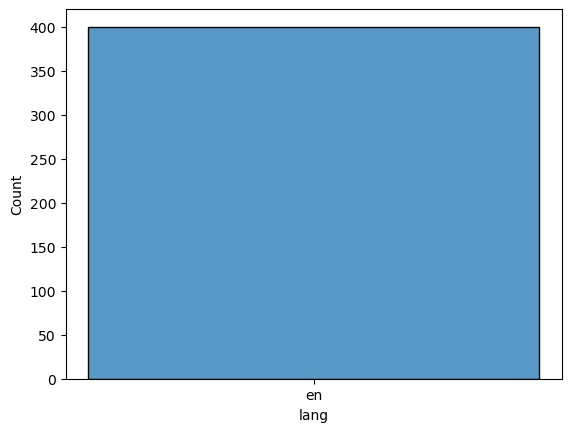

In [4]:
import seaborn as sns
sns.histplot(df_train, x='lang')

<Axes: xlabel='lang', ylabel='Count'>

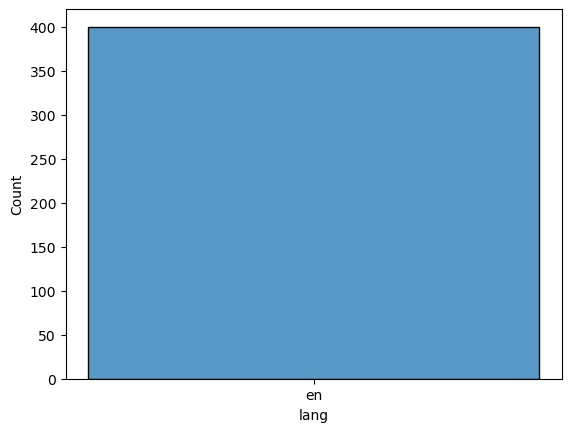

In [19]:
max_rows = df_train['lang'].value_counts().max()

# Function to oversample a given language
def oversample_language(df, lang, max_rows):
    df_lang = df[df['lang'] == lang]
    if len(df_lang) < max_rows:
        oversampled_lang = df_lang.sample(max_rows, replace=True)
    else:
        oversampled_lang = df_lang
    return oversampled_lang

# Get a list of all languages in the dataset
languages = df_train['lang'].unique()

# Oversample each language
oversampled_dfs = [oversample_language(df_train, lang, max_rows) for lang in languages]

# Concatenate all oversampled dataframes
balanced_df = pd.concat(oversampled_dfs)

# Shuffle the resulting dataframe
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

sns.histplot(balanced_df, x='lang')

In [22]:
labels = [i.split() for i in df_train['ner_tags_str'].values.tolist()]

unique_labels = set(lbl for seq in labels for lbl in seq)

labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}

**Load Tokenizer**

In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_acc_loss(train_acc_history, val_acc_history, train_loss_history, val_loss_history):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

  sns.lineplot(x=range(len(train_acc_history)), y=train_acc_history, ax=ax[0], label='Train Accuracy')
  sns.lineplot(x=[len(train_acc_history)//len(val_acc_history)*i for i in range(len(val_acc_history))], 
               y=val_acc_history, 
               ax=ax[0], 
               label='Validation Accuracy')
  
  ax[0].set_title('Accuracy History')

  sns.lineplot(x=range(len(train_loss_history)), y=train_loss_history, ax=ax[1], label='Train Loss')
  sns.lineplot(x=[len(train_loss_history)//len(val_loss_history)*i for i in range(len(val_loss_history))], 
               y=val_loss_history, 
               ax=ax[1], 
               label='Validation Loss')
  
  ax[1].set_title('Loss History')

**Training**

In [7]:
import torch
import copy
from torch.optim import SGD
from torch.utils.data import DataLoader

from tqdm import tqdm

from src.models.bert_model import BertModel
from src.data.data_sequence import DataSequence

LEARNING_RATE = 3e-3
EPOCHS = 5
BATCH_SIZE = 2

def train_loop(model, df_train, df_val):
    train_dataset = DataSequence(df_train, tokenizer)
    val_dataset = DataSequence(df_val, tokenizer)

    train_dataloader = DataLoader(train_dataset, num_workers=0, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(val_dataset, num_workers=0, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()

    use_mps = False
    
    device = torch.device("mps" if use_mps else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_mps:
        model.to(device)
    elif use_cuda:
        model = model.cuda()

    print(f"Running on: {device}")

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []

    #Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_model_weights = None
    patience = 2

    for epoch_num in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0

        model.train()

        pbar = tqdm(total=len(df_train)/BATCH_SIZE, desc=f"[Epoch: {epoch_num + 1}] [Acc: {0}]")
        for idx, batch_data in enumerate(train_dataloader):
            train_data, train_label = batch_data

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

                logits_clean = logits[i][train_label[i] != -100]
                label_clean = train_label[i][train_label[i] != -100]

                predictions = logits_clean.argmax(dim=1)
                acc = (predictions == label_clean).float().mean()
                total_acc_train += acc
                total_loss_train += loss.item()

            train_acc_history.append((total_acc_train / ((idx+1)*2) ))
            train_loss_history.append((total_loss_train / ((idx+1)*2) ))

            loss.backward()
            optimizer.step()

            pbar.set_description(f"[Epoch: {epoch_num + 1}] [Acc: {(total_acc_train / ((idx + 1) * BATCH_SIZE)):.3f}]")

            pbar.update(1)

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            pbar = tqdm(total=len(df_val)/BATCH_SIZE, desc=f"[Validation Acc: {0}]")
            for idx, batch_data in enumerate(val_dataloader):
                val_data, val_label = batch_data
    
                val_label = val_label.to(device)
                mask = val_data['attention_mask'].squeeze(1).to(device)
                input_id = val_data['input_ids'].squeeze(1).to(device)
    
                loss, logits = model(input_id, mask, val_label)
    
                for i in range(logits.shape[0]):
                    logits_clean = logits[i][val_label[i] != -100]
                    label_clean = val_label[i][val_label[i] != -100]
    
                    predictions = logits_clean.argmax(dim=1)
                    acc = (predictions == label_clean).float().mean()
                    total_acc_val += acc
                    total_loss_val += loss.item()
    
                val_acc_history.append((total_acc_val / ((idx+1)*2) ))
                val_loss_history.append((total_loss_val / ((idx+1)*2) ))

                pbar.set_description(f"[Validation Acc: {(total_acc_val / ((idx + 1) * BATCH_SIZE)):.3f}]")

                pbar.update(1)

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num+1} \
            | Loss: {total_loss_train / len(df_train): .3f} \
            | Accuracy: {total_acc_train / len(df_train): .3f} \
            | Val Loss: {total_loss_val / len(df_val): .3f} \
            | Val Accuracy: {total_acc_val / len(df_val): .3f}' \
        )

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
            patience = 2  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print('Early Stopping Triggered')
                break
    
    train_acc_history = [tensor.item() if isinstance(tensor, torch.Tensor) else tensor for tensor in train_acc_history]
    train_loss_history = [tensor.item() if isinstance(tensor, torch.Tensor) else tensor for tensor in train_loss_history]

    val_acc_history = [tensor.item() if isinstance(tensor, torch.Tensor) else tensor for tensor in val_acc_history]
    val_loss_history = [tensor.item() if isinstance(tensor, torch.Tensor) else tensor for tensor in val_loss_history]

    plot_acc_loss(train_acc_history, val_acc_history, train_loss_history, val_loss_history)

    return best_model_weights

model = BertModel(7)
best_model_weights = train_loop(model, df_train, df_val)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on: cpu


[Epoch: 1] [Acc: 0.378]:   8%|▊         | 6/80.0 [00:21<04:40,  3.79s/it]

KeyboardInterrupt: 

In [22]:
#torch.save(model.state_dict(), 'models/var_model.pth')

In [11]:
def evaluate(model, df_test):
    test_dataset = DataSequence(df_test)
    test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1)

    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    device = torch.device("mps" if use_mps else "cpu")

    if use_mps:
        model.to(device)
    elif use_cuda:
        model = model.cuda()

    print(f"Running on: {device}")

    total_acc_test = 0.0

    pbar = tqdm(total=len(df_test), desc=f"[Test Accuracy: {0}]")
    for idx, batch_data in enumerate(test_dataloader):
        test_data, test_label = batch_data
        test_label = test_label.to(device)
        
        mask = test_data['attention_mask'].squeeze(1).to(device)
        input_id = test_data['input_ids'].squeeze(1).to(device)

        loss, logits = model(input_id, mask, test_label)

        for i in range(logits.shape[0]):
            logits_clean = logits[i][test_label[i] != -100]
            label_clean = test_label[i][test_label[i] != -100]

            predictions = logits_clean.argmax(dim=1)
            acc = (predictions == label_clean).float().mean()
            total_acc_test += acc

        pbar.set_description(f"[Test Accuracy: {(total_acc_test / ((idx + 1))):.3f}]")

        pbar.update(1)

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {val_accuracy: .3f}')

evaluate(model, df_test)

Running on: mps


[Test Accuracy: 0]:   0%|          | 0/5800 [00:00<?, ?it/s]

Test Accuracy:  0.898


In [12]:
test_model = BertModel()
test_model.load_state_dict(best_model_weights)
test_model.eval()
evaluate(test_model, df_test)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on: mps


[Test Accuracy: 0]:   0%|          | 0/5800 [00:00<?, ?it/s]

Test Accuracy:  0.895


In [29]:
test_train, test_val, test_test = load_data(langs=['ur'], nrows=1000)
evaluate(model, test_train)

Fetching Language Data:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Language Data:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/lucasgranucci/anaconda3/envs/nlp_rsrch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Running on: mps


[Test Accuracy: 0]:   0%|          | 0/800 [00:00<?, ?it/s]

Test Accuracy:  0.520


In [74]:
def align_word_ids(texts, label_all_tokens):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)
    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx
    return label_ids

def evaluate_one_text(model, sentence):
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    device = torch.device("mps" if use_mps else "cpu")

    if use_mps:
        model.to(device)
    elif use_cuda:
        model = model.cuda()

    print(f"Running on: {device}")

    text = tokenizer(sentence, padding='max_length', max_length=512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence, label_all_tokens=False)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)

In [31]:
evaluate_one_text(model, "昨日、 韓国人でいっぱいの船が日本に着きました。 外務省の上川陽子が危機を「もう解けた事態」と呼びました。")

Running on: mps
昨日、 韓国人でいっぱいの船が日本に着きました。 外務省の上川陽子が危機を「もう解けた事態」と呼びました。
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [19]:
#torch.save(model.state_dict(), 'models/ger_rom_model.pth')

In [72]:
import torch

test_model = BertModel(len(unique_labels))
test_model.load_state_dict(torch.load('models/var_model.pth'))
test_model.eval()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (bert): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bia

In [75]:
evaluate_one_text(test_model, "In 2023, Elon Musk met with executives from Google at their headquarters in Mountain View, California, to discuss advancements in artificial intelligence.")

Running on: mps
In 2023, Elon Musk met with executives from Google at their headquarters in Mountain View, California, to discuss advancements in artificial intelligence.
['O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
